In [1]:
# * 20230822 plot一下那个分割的结果
import numpy as np
import torch
import torchio as tio

def create_boxmask(gtbox, predbox, image_shape, name):
    # 创建全零数组
    mask = np.zeros(image_shape, dtype=np.uint8)
    
    # 将gtbox区域设置为1
    for box in gtbox:
        x1, y1, z1, x2, y2, z2 = box
        mask[z1:z2+1, y1:y2+1, x1:x2+1] = 1
        
    # 将predbox区域设置为2
    for box in predbox:
        x1, y1, z1, x2, y2, z2 = box[1:]
        mask[z1:z2+1, y1:y2+1, x1:x2+1] = 2
        
    # 将重合区域设置为3
    mask[(mask == 1) & (mask == 2)] = 3
    
    # 转换为向量并增加维度
    # mask_vector = mask.flatten()
    mask_tensor = torch.tensor(mask, dtype=torch.uint8).unsqueeze(0)
    affine = [[0.7, 0, 0, 0],
              [0, 0.7, 0, 0],
              [0, 0, 1.2, 0],
              [0, 0,   0, 1]]
    
    mask_nii = tio.ScalarImage(tensor=mask_tensor, affine=affine)
    mask_nii.save(f'/public_bme/data/xiongjl/det/nii_temp/{name}_boxmask.nii.gz')
    

def select_box(predbox, p):
    selected_box = []
    for box in predbox:
        i = box[0]
        if i >= p:
            selected_box.append(box)
    return selected_box



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter


def create_gaussian(size):

    if size % 2 != 1:  # 如果size是偶数就变成奇数
        dis = size / 2.
        sigma = np.sqrt(dis**2 / (2 * (np.log(5) - np.log(4)))) # 0.8
        # sigma = np.sqrt(dis**2 / (2 * np.log(2))) # 0.5
        size = size + 1
        print(size)
    else:
        dis = (size + 1) / 2.
        print(size)
        sigma = np.sqrt(dis**2 / (2 * (np.log(5) - np.log(4))))
        
    kernel = np.zeros((int(size * 2 + 1), int(size * 2 + 1), int(size * 2 + 1)))
    center = tuple(s // 2 for s in (int(size * 2 + 1), int(size * 2 + 1), int(size * 2 + 1)))
    kernel[center] = 1
    # if size // 6 <= 3:
    #     sigma = 3
    # else:
    #     sigma = size // 6
    gassian_kernel = gaussian_filter(kernel, sigma=sigma)
    arr_min = gassian_kernel.min()
    arr_max = gassian_kernel.max()
    normalized_arr = (gassian_kernel - arr_min) / (arr_max - arr_min) # 归一化到 0-1 之间

    return normalized_arr


In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_center_slices_3d_decimal(array, cube_size):
    center_x = array.shape[0] // 2
    center_y = array.shape[1] // 2
    center_z = array.shape[2] // 2

    # plot the bbox
    # array[]
    plt.figure(figsize=(12, 4))
    
    plt.subplot(131)
    plt.imshow(array[center_x, :, :], cmap='gray')
    plt.title('YZ Plane')
    for i in range(array.shape[1]):
        for j in range(array.shape[2]):
            plt.text(j, i, f'{array[center_x, i, j]:.1f}', color='red', fontsize=4)
    
    plt.subplot(132)
    plt.imshow(array[:, center_y, :], cmap='gray')
    plt.title('XZ Plane')
    for i in range(array.shape[0]):
        for j in range(array.shape[2]):
            plt.text(j, i, f'{array[i, center_y, j]:.1f}', color='red', fontsize=4)
    
    plt.subplot(133)
    plt.imshow(array[:, :, center_z], cmap='gray')
    plt.title('XY Plane')
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            plt.text(j, i, f'{array[i, j, center_z]:.1f}', color='red', fontsize=4)

    # Add cube outline
    cube_outline = patches.Rectangle(
        (center_z - cube_size/2, center_y - cube_size/2),
        cube_size, cube_size, linewidth=1, edgecolor='r', facecolor='none'
    )

    plt.subplot(133)
    plt.gca().add_patch(cube_outline)
    plt.tight_layout()
    plt.show()



def combine_gaussian_kernels(kernel_large, kernel_small):
    # print(kernel_large.shape)
    center_large = np.array(kernel_large.shape) // 2
    # print(center_large)
    # print(kernel_small.shape)
    small_shape = np.array(kernel_small.shape[0]) // 2
    # print(small_shape)

    kernel_large[center_large[0] - small_shape:center_large[0] + small_shape+1, 
                 center_large[1] - small_shape:center_large[1] + small_shape+1, 
                 center_large[2] - small_shape:center_large[2] + small_shape+1, ] += kernel_small[:, :, :]

    arr_min = kernel_large.min()
    arr_max = kernel_large.max()
    normalized_arr = (kernel_large - arr_min) / (arr_max - arr_min) # 归一化到 0-1 之间

    return normalized_arr

from time import time
time_1 = time()
# Replace 'your_array' with the actual 3D array you want to visualize
your_array = create_gaussian(20)
array_2 = create_gaussian(15)
combined_kernel = combine_gaussian_kernels(your_array, array_2)
print(f'time is {time() - time_1}') 
# plot_center_slices_3d_decimal(combined_kernel, 20)
# Get the central slice of the combined kernel
# center_slice = combined_kernel[
#     combined_kernel.shape[0] // 2,
#     combined_kernel.shape[1] // 2,
#     :
# ]
# Plot the central slice as a curve
# x_values = np.arange(center_slice.shape[0])
# plt.plot(x_values, center_slice)
# plt.xlabel('Position along the axis')
# plt.ylabel('Kernel values')
# plt.title('Curve of Gaussian Kernel along Center')
# plt.show()


21
15
time is 0.00700831413269043


In [ ]:
# 这里最好是自己设计一个函数去做到这个事情
import sympy as sp
import numpy as np

def solve_cubic_function(size):
    # Define the variables and coefficients
    x = sp.symbols('x')
    a, b, c, d, size = sp.symbols('a b c d size')

    # Define the cubic polynomial
    # polynomial = a * x**3 + b * x**2  + 1
    polynomial = a * sp.cos(b * x) + c * sp.cos(d * x)

    # Given conditions
    conditions = [
        (0, 1, 0),           # Point (0, 1) with derivative 0
        (size, 0.5, None),   # Point (size, 0.5) with unknown derivative
        (1.5 * size, 0, 0),  # Point (1.5 * size, 0) with derivative 0
    ]

    # Set up equations based on the conditions
    equation_1 = a * sp.cos(b * 0) + c * sp.cos(d * 0) -1 
    equation_2 = a * sp.cos(b * size) + c * sp.cos(d * size) - 0.5 
    equation_3 = a*b * (-1)*sp.sin(b * 0) + c *d* (-1)*sp.sin(d * 0)
    equation_4 = a*b * (-1)*sp.sin(b * (size+8)) + c *d* (-1)*sp.sin(d * (size+8))
    

    # for x_val, y_val, derivative in conditions:
    #     equation = polynomial.subs(x, x_val) - y_val
    #     equations.append(equation)
    #     if derivative is not None:
    #         derivative_equation = sp.diff(polynomial, x).subs(x, x_val) - derivative
    #         equations.append(derivative_equation)

    # Solve the equations for the coefficients
    solution = sp.solve((equation_1, equation_2, equation_3, equation_4), (a, b, c, d))
    print(solution)
    
    # Construct the polynomial function
    cubic_function = polynomial.subs(solution)
    # print(cubic_func)
    
    return cubic_function

size = 10  # Adjust the size as needed
cubic_func = solve_cubic_function(size)
print(cubic_func)



#* summary 以失败告终。找不到很合适的方程来描绘我所需要的要求，这个时候还是直接使用两个高斯核相互叠交


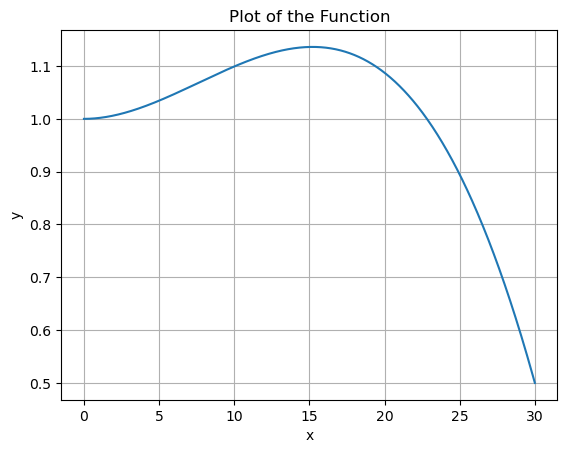

In [63]:
import numpy as np
import matplotlib.pyplot as plt

def plot_function(func, x_range=(0, 30), num_points=1000):
    x_vals = np.linspace(x_range[0], x_range[1], num_points)
    y_vals = [func(x) for x in x_vals]
    
    plt.plot(x_vals, y_vals)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Plot of the Function')
    plt.grid(True)
    plt.show()

# Define your function here
def my_function(x, size=30):
    # return 26/(27 * (size**4)) * (x**4) + ((-62)/(27 * (size**3)) * (x**3)) + ((5)/(6 * (size**2)) * (x**2)) + 1
    # return x**4*(size**3 + 12.0*size**2 - 48.0*size - 64.0)/(32.0*size**5 + 384.0*size**4 + 1536.0*size**3 + 2048.0*size**2) + x**3*(-size**4 - 16.0*size**3 + 32.0*size**2 + 256.0*size + 256.0)/(16.0*size**5 + 192.0*size**4 + 768.0*size**3 + 1024.0*size**2) + x**2*(size**4 + 16.0*size**3 - 96.0*size**2 - 256.0*size - 256.0)/(32.0*size**4 + 256.0*size**3 + 512.0*size**2) + 1
    return x**3*(-size**2 + 8.0*size + 16.0)/(8.0*size**4 + 64.0*size**3 + 128.0*size**2) + x**2*(size**3 - 12.0*size**2 - 48.0*size - 64.0)/(8.0*size**4 + 64.0*size**3 + 128.0*size**2) + 1
# Call the plot_function with your function
plot_function(my_function)


In [41]:
import sympy as sp

# Define the variable
x = sp.symbols('x')

# Define the equation
equation = x**2 - 4

# Solve the equation for x
solutions = sp.solve(equation, x)
print(solutions)

[-2, 2]


In [3]:
import numpy as np
x = np.array([[1,1,1],[1,1,1],[1,1,1]])
print(x*10)


[[10 10 10]
 [10 10 10]
 [10 10 10]]
